<a href="https://colab.research.google.com/github/aribamazharam/Stick_Blur_Classification/blob/main/StickBlurClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install timm
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import timm
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import seaborn as sn
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 30.3 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5 - Train Acc: 0.7833, Val Acc: 0.7667
Epoch 2/5 - Train Acc: 0.8792, Val Acc: 0.9500
Epoch 3/5 - Train Acc: 0.9229, Val Acc: 0.8667
Epoch 4/5 - Train Acc: 0.9542, Val Acc: 0.9333
Epoch 5/5 - Train Acc: 0.9792, Val Acc: 0.9333


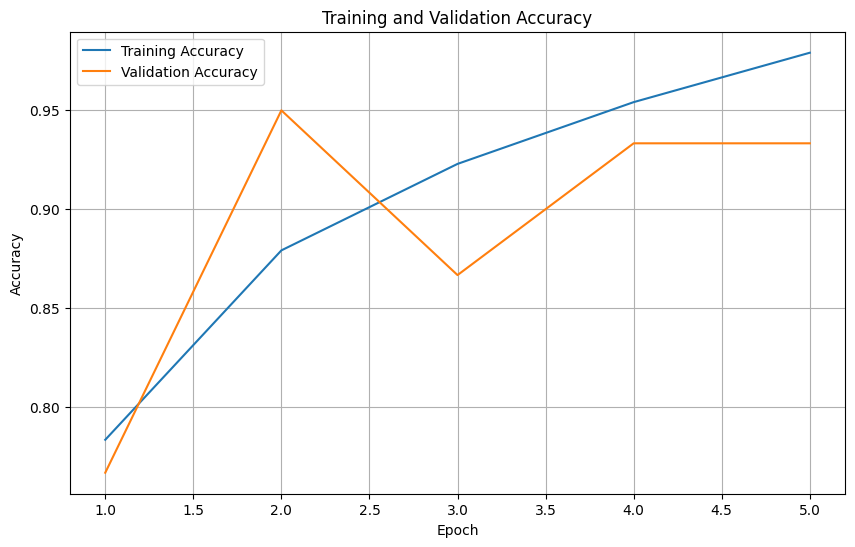

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load datasets
train_dataset = datasets.ImageFolder('/content/drive/MyDrive/Golf_Stick_Dataset/train', transform=transform)
valid_dataset = datasets.ImageFolder('/content/drive/MyDrive/Golf_Stick_Dataset/valid', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

# Load model
model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5
train_accuracies, val_accuracies = [], []

for epoch in tqdm(range(num_epochs)):
    model.train()
    train_preds, train_targets = [], []
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        train_targets.extend(labels.cpu().numpy())

    train_acc = accuracy_score(train_targets, train_preds)
    train_accuracies.append(train_acc)

    model.eval()
    val_preds, val_targets = [], []
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            val_targets.extend(labels.cpu().numpy())

    val_acc = accuracy_score(val_targets, val_preds)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch + 1}/{num_epochs} - Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

# Save the model
torch.save(model.state_dict(), '/content/drive/MyDrive/Golf_Stick_Dataset/efficientnet_b0_golfstick.pth')

# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Load the test dataset
test_dataset = datasets.ImageFolder('/content/drive/MyDrive/Golf_Stick_Dataset/test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load the saved model
model.load_state_dict(torch.load('/content/drive/MyDrive/Golf_Stick_Dataset/efficientnet_b0_golfstick.pth'))
model.eval()

test_preds, test_targets = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        test_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        test_targets.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(test_targets, test_preds)
test_precision = precision_score(test_targets, test_preds)
test_recall = recall_score(test_targets, test_preds)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

Test Accuracy: 0.9194
Test Precision: 0.9643
Test Recall: 0.8710


In [ ]:
import cv2
import os
from PIL import Image

video_path = '/content/drive/MyDrive/Golf_Stick_Dataset/16-FaceOn_240fps.mp4'
cap = cv2.VideoCapture(video_path)

blur_dir = '/content/drive/MyDrive/Golf_Stick_Dataset/frames/blur'
no_blur_dir = '/content/drive/MyDrive/Golf_Stick_Dataset/frames/no_blur'
os.makedirs(blur_dir, exist_ok=True)
os.makedirs(no_blur_dir, exist_ok=True)

frame_number = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(frame_rgb)  # Convert numpy array to PIL image
    frame_tensor = transform(pil_image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(frame_tensor)
        pred = torch.argmax(output, dim=1).item()

    print(f"Frame {frame_number}: Output = {output}, Prediction = {pred}")  # Added print statement

    if pred == 0:  # Assuming 0 is for 'blur' class
        cv2.imwrite(os.path.join(blur_dir, f'frame_{frame_number}.jpg'), frame)
    else:
        cv2.imwrite(os.path.join(no_blur_dir, f'frame_{frame_number}.jpg'), frame)

    frame_number += 1

cap.release()


In [11]:
import cv2
import os
from PIL import Image

video_path = '/content/drive/MyDrive/Golf_Stick_Dataset/16-FaceOn_240fps.mp4'
cap = cv2.VideoCapture(video_path)

blur_dir = '/content/drive/MyDrive/Golf_Stick_Dataset/frames/blur'
no_blur_dir = '/content/drive/MyDrive/Golf_Stick_Dataset/frames/no_blur'
os.makedirs(blur_dir, exist_ok=True)
os.makedirs(no_blur_dir, exist_ok=True)

frame_number = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(frame_rgb)  # Convert numpy array to PIL image
    frame_tensor = transform(pil_image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(frame_tensor)
        pred = torch.argmax(output, dim=1).item()

    print(f"Frame {frame_number}: Output = {output}, Prediction = {pred}")  # Added print statement

    if pred == 0:  # Assuming 0 is for 'blur' class
        cv2.imwrite(os.path.join(blur_dir, f'frame_{frame_number}.jpg'), frame)
    else:
        cv2.imwrite(os.path.join(no_blur_dir, f'frame_{frame_number}.jpg'), frame)

    frame_number += 1

cap.release()

Frame 0: Output = tensor([[-21.1854,  18.5127]], device='cuda:0'), Prediction = 1
Frame 1: Output = tensor([[-22.0377,  19.3464]], device='cuda:0'), Prediction = 1
Frame 2: Output = tensor([[-21.3931,  18.8387]], device='cuda:0'), Prediction = 1
Frame 3: Output = tensor([[-20.2989,  17.7373]], device='cuda:0'), Prediction = 1
Frame 4: Output = tensor([[-21.8375,  19.7797]], device='cuda:0'), Prediction = 1
Frame 5: Output = tensor([[-21.6369,  19.7361]], device='cuda:0'), Prediction = 1
Frame 6: Output = tensor([[-24.2525,  22.4823]], device='cuda:0'), Prediction = 1
Frame 7: Output = tensor([[-24.9485,  23.0842]], device='cuda:0'), Prediction = 1
Frame 8: Output = tensor([[-27.2134,  25.5848]], device='cuda:0'), Prediction = 1
Frame 9: Output = tensor([[-32.4315,  30.5184]], device='cuda:0'), Prediction = 1
Frame 10: Output = tensor([[-34.5097,  32.6325]], device='cuda:0'), Prediction = 1
Frame 11: Output = tensor([[-36.3918,  34.2747]], device='cuda:0'), Prediction = 1
Frame 12: Outp